In [ ]:
ooo,mfrom __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.keras import Input

SyntaxError: ignored

In [ ]:
import numpy as np

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D,LSTM,Bidirectional,Attention,Concatenate
from tensorflow.keras.layers import DepthwiseConv2D,Add, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Activation,ActivityRegularization, AvgPool2D,Conv1D, MaxPooling1D
from tensorflow.keras import regularizers, optimizers,losses
from tensorflow.keras.metrics import Recall,Precision,AUC,TruePositives,TrueNegatives,FalseNegatives,FalsePositives, SpecificityAtSensitivity,SensitivityAtSpecificity
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
#import imblearn
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#%cd /content/drive/MyDrive/
#%ls

Mounted at /content/drive


In [ ]:
img_shape=(128,128,3)
rel_dirname='/content/drive/MyDrive/Colab Notebooks/Multimodal1'
Name= 'Multimodal1'
dir1="/content/drive/MyDrive/Colab Notebooks/Multimodal1/D1"
dir2="/content/drive/MyDrive/Colab Notebooks/Multimodal1/D2"

In [ ]:
import cv2
import os
DF1=[]
DF2=[]
label=[]
for dirname in sorted(os.listdir(dir1)):
    for filename in sorted(os.listdir(((os.path.join(dir1,dirname)))))[:105]:
      img = cv2.imread((os.path.join(dir1,dirname,filename)), cv2.IMREAD_GRAYSCALE)
      img = image.img_to_array(img)
      img = img/255
      img = cv2.resize(img, (28, 28))
      DF1.append(img)
      # label.append(dirname)

for dirname in sorted(os.listdir(dir2)):
    for filename in sorted(os.listdir(((os.path.join(dir2,dirname))))):
      img = cv2.imread((os.path.join(dir2,dirname,filename)), cv2.IMREAD_GRAYSCALE)
      img = image.img_to_array(img)
      img = img/255
      img = cv2.resize(img, (28, 28))
      DF2.append(img)
      label.append(dirname)
       #print(img.shape)



In [ ]:
df1=np.array(DF1)
df2=np.array(DF2)
y = np.array(label)
# y=to_categorical(label)
print(df1.shape)
print(df2.shape)
print(y.shape)

(210, 28, 28)
(210, 28, 28)
(210,)


In [ ]:
df1_train, df1_test, df2_train, df2_test, y_train, y_test = train_test_split(df1,df2,y,random_state=7, test_size=0.20)

In [ ]:
image_size = df1_train.shape[1]
df1_train = np.reshape(df1_train,[-1, image_size, image_size, 1])
df1_test = np.reshape(df1_test,[-1, image_size, image_size, 1])

df2_train = np.reshape(df2_train,[-1, image_size, image_size, 1])
df2_test = np.reshape(df2_test,[-1, image_size, image_size, 1])

Left Encoder

In [ ]:
from keras.layers import concatenate
from keras import Model
from tensorflow.keras import Input

In [ ]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

# left branch of Y network
left_inputs = Input(shape=input_shape)

##################################
encoding_dim = 32
encoded = Dense(encoding_dim, activation='relu')(left_inputs)
# e = Dense()(left_inputs)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# # encoder level 2
# e = Dense()(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# # bottleneck
# n_bottleneck = round(float(input_shape) / 2.0)
# bottleneck = Dense(n_bottleneck)(e)
##################################
x = encoded
# x = left_inputs
filters = n_filters
for i in range(3):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2

# right branch of Y network
right_inputs = Input(shape=input_shape)
y = right_inputs
filters = n_filters
for i in range(3):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

# merge left and right branches outputs
y = concatenate([x, y])
# feature maps to vector before connecting to Dense
y = Flatten()(y)
y = Dropout(dropout)(y)
num_labels = 2
outputs = Dense(num_labels, activation='sigmoid')(y)

# build the model in functional API
model = Model([left_inputs, right_inputs], outputs)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 28, 28, 32)   64          ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   9248        ['dense[0][0]']                  
                                                                                              

In [ ]:
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# train the model with input images and labels
model.fit([df1_train, df2_train],
          y_train,
          validation_data=([df1_test, df2_test], y_test),
          epochs=50,
          batch_size=batch_size)

Epoch 1/50
6/6 [==============================] - 15s 217ms/step - loss: 0.6608 - accuracy: 0.6369 - val_loss: 0.6491 - val_accuracy: 0.8810
Epoch 2/50
6/6 [==============================] - 0s 14ms/step - loss: 0.5499 - accuracy: 0.7798 - val_loss: 0.5964 - val_accuracy: 0.8571
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.4240 - accuracy: 0.8452 - val_loss: 0.5235 - val_accuracy: 0.9762
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 0.3149 - accuracy: 0.8988 - val_loss: 0.4522 - val_accuracy: 0.9762
Epoch 5/50
6/6 [==============================] - 0s 18ms/step - loss: 0.2085 - accuracy: 0.9405 - val_loss: 0.3916 - val_accuracy: 0.9286
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.1670 - accuracy: 0.9464 - val_loss: 0.3393 - val_accuracy: 0.9286
Epoch 7/50
6/6 [==============================] - 0s 17ms/step - loss: 0.1672 - accuracy: 0.9167 - val_loss: 0.3273 - val_accuracy: 0.9524
Epoch 8/50
6/6 [=========

In [ ]:
score = model.evaluate([df1_test, df2_test],
                       y_test,
                       batch_size=batch_size,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 95.2%


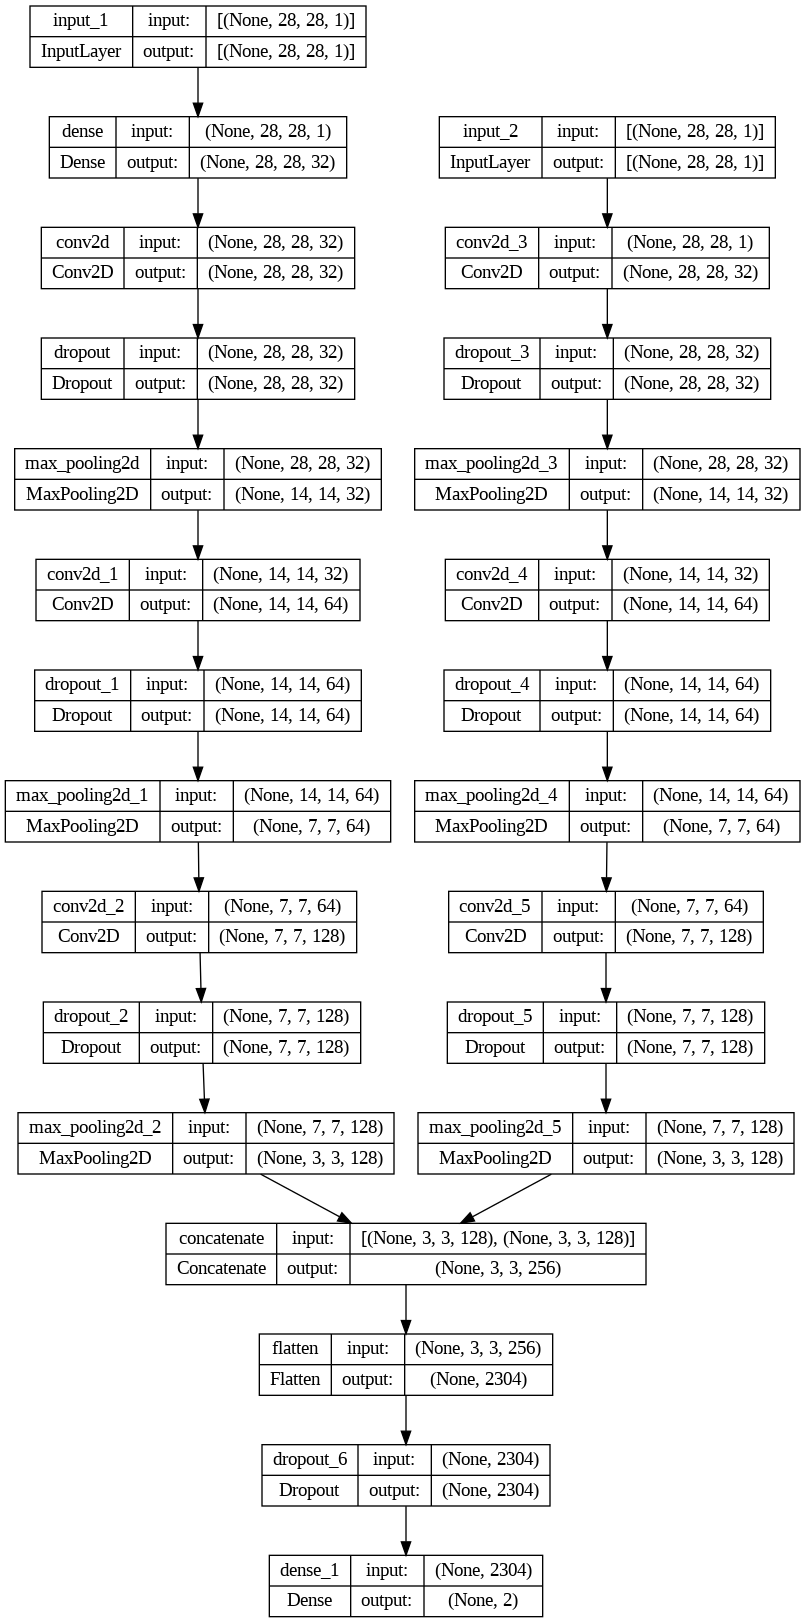

In [ ]:
plot_model(model, to_file=Name+'.png',show_shapes= True , show_layer_names=True)

RIGHT ENCODER

In [ ]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

# left branch of Y network
left_inputs = Input(shape=input_shape)

##################################
# encoder level 1

# e = Dense()(left_inputs)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# # encoder level 2
# e = Dense()(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# # bottleneck
# n_bottleneck = round(float(input_shape) / 2.0)
# bottleneck = Dense(n_bottleneck)(e)
##################################
x = left_inputs
filters = n_filters
for i in range(3):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2

# right branch of Y network
right_inputs = Input(shape=input_shape)
encoding_dim = 32
encoded = Dense(encoding_dim, activation='relu')(right_inputs)


y = encoded
filters = n_filters
for i in range(3):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

# merge left and right branches outputs
y = concatenate([x, y])
# feature maps to vector before connecting to Dense
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='sigmoid')(y)

# build the model in functional API
model1 = Model([left_inputs, right_inputs], outputs)

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
# train the model with input images and labels
model1.fit([df1_train, df2_train],
          y_train,
          validation_data=([df1_test, df2_test], y_test),
          epochs=50,
          batch_size=batch_size)

Epoch 1/50
6/6 [==============================] - 4s 148ms/step - loss: 0.6542 - accuracy: 0.5536 - val_loss: 0.6467 - val_accuracy: 0.7381
Epoch 2/50
6/6 [==============================] - 0s 25ms/step - loss: 0.5305 - accuracy: 0.7917 - val_loss: 0.5870 - val_accuracy: 0.8095
Epoch 3/50
6/6 [==============================] - 0s 23ms/step - loss: 0.4022 - accuracy: 0.8274 - val_loss: 0.4994 - val_accuracy: 0.9524
Epoch 4/50
6/6 [==============================] - 0s 23ms/step - loss: 0.2914 - accuracy: 0.8929 - val_loss: 0.4291 - val_accuracy: 0.9762
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 0.2074 - accuracy: 0.9107 - val_loss: 0.3836 - val_accuracy: 0.9762
Epoch 6/50
6/6 [==============================] - 0s 23ms/step - loss: 0.1384 - accuracy: 0.9762 - val_loss: 0.3343 - val_accuracy: 0.9762
Epoch 7/50
6/6 [==============================] - 0s 22ms/step - loss: 0.1142 - accuracy: 0.9702 - val_loss: 0.2942 - val_accuracy: 0.9762
Epoch 8/50
6/6 [==========

In [ ]:
score = model1.evaluate([df1_test, df2_test],
                       y_test,
                       batch_size=batch_size,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 100.0%


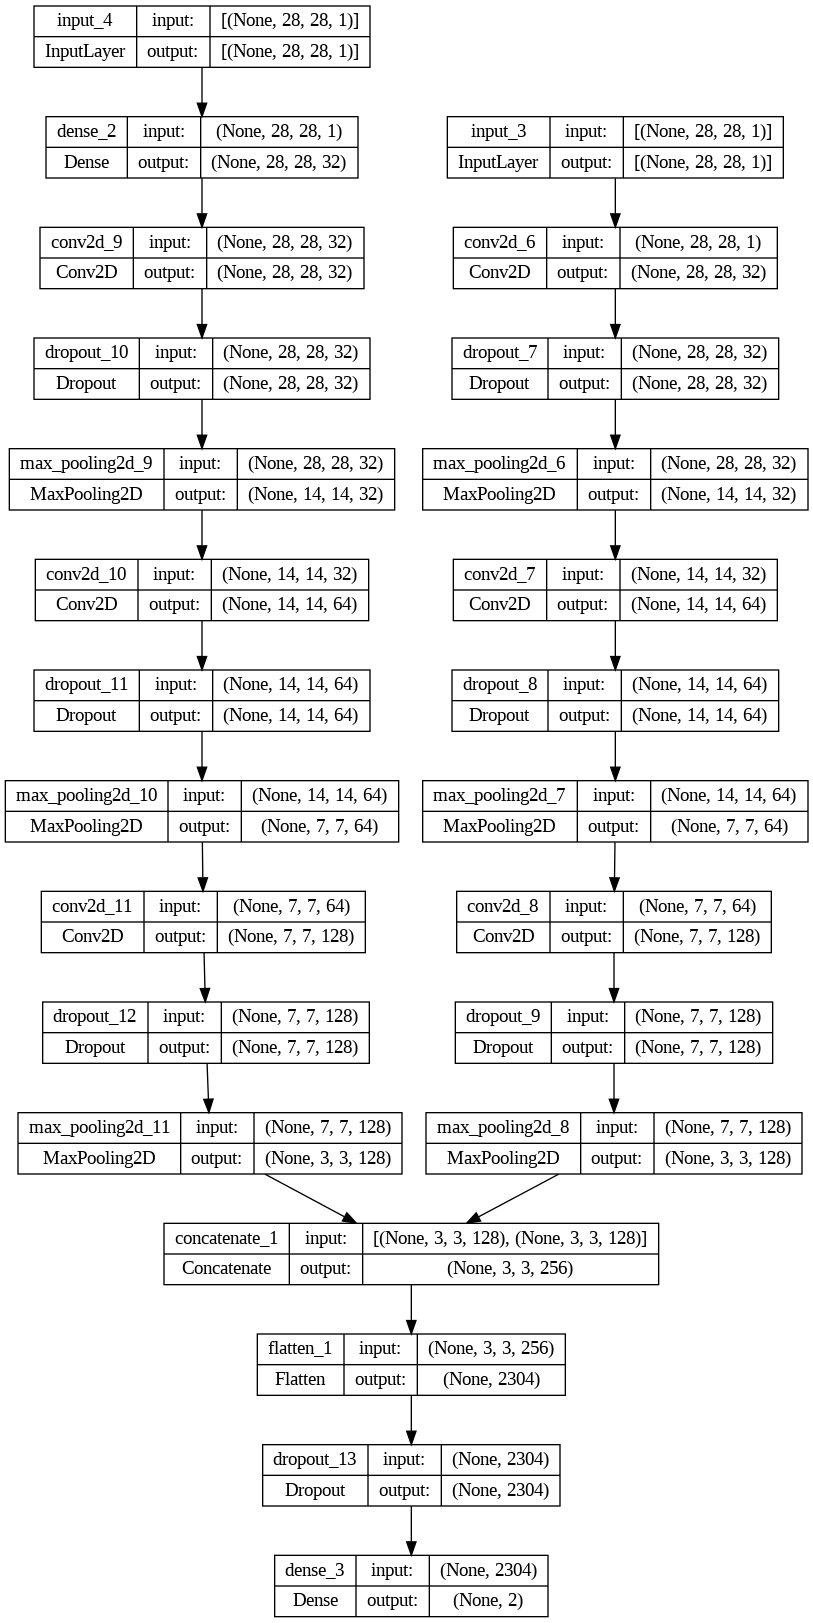

In [ ]:
plot_model(model1, to_file=Name+'.png',show_shapes= True , show_layer_names=True)